In [2]:
%pip install qiskit qiskit-ibm-runtime
%pip install qiskit
%pip install qiskit[visualization]
%pip install pylatexenc
%pip install qiskit qiskit-aer --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=8280a183ea60b823a4bff907b5ef8cf5ec64daf219994f6dafd882b30a21b789
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [23]:

%matplotlib inline

from qiskit import *
from qiskit.visualization import *
#from qiskit.tools.monitor import *
from qiskit.quantum_info import Operator

import numpy as np

def init_grover(q):
    circ = QuantumCircuit(q)

    n = len(q)

    circ.x(n-1) # The qubit that receives the oracle output must be set to |1>
    for i in range(n):
        circ.h(q[i])

    circ.barrier()
    circ.draw()
    return circ

In [44]:
def diffusion(q):

    circ = QuantumCircuit(q)

    # Diffusion operator

    n = len(q)

    for i in range(n-1):
        circ.h(q[i])

    for i in range(n-1):
        circ.x(q[i])

    # To implement a multicontrolled Z we use a multicontrolled Z rotation


    if(n>2):
        circ.mcrz(np.pi,q[0:n-3],q[n-2])
        #mcz.z(q[0])
    else:
        circ.z(q[0]) # If there is only input qubit for the oracle, we don't have controls

    #circ.mcrz(np.pi,q[0:n-3],q[n-2])
    #circ.append(mcz.to_instruction(),q_dif)

    for i in range(n-1):
        circ.x(q[i])

    for i in range(n-1):
        circ.h(q[i])

    circ.barrier()

    return circ

In [45]:
def ones(q):

    # We will use a multicontrolled X gate

    circ = QuantumCircuit(q)

    n = len(q)

    circ.mcx(q[0:n-2],q[n-2])

    return circ

In [46]:
def grover(n, oracle, it = 10, measurement = True):

    q = QuantumRegister(n, name = 'q')
    if(measurement):
        c = ClassicalRegister(n-1,name='c') # measure the qubits that are the input to the oracle
        circ = QuantumCircuit(q,c)
    else:
        circ = QuantumCircuit(q)

    circ.compose(init_grover(q),inplace=True) #

    for _ in range(it):
        circ.compose(oracle(q),inplace=True)
        circ.compose(diffusion(q),inplace=True)
    # circ=circ  + oracle(q)
        #circ=circ  + difussion(q)

    if(measurement):  # Measurements
        circ.measure(q[0:n-2],c)

    return circ

In [47]:
def mgrover(n, oracle, it = 10, measurement = True):

    q = QuantumRegister(n, name = 'q')
    if(measurement):
        c = ClassicalRegister(n-1,name='c') # measure the qubits that are the input to the oracle
        circ = QuantumCircuit(q,c)
    else:
        circ = QuantumCircuit(q)

    circ.compose(init_grover(q),inplace=True)

    for _ in range(it):
        circ.compose(oracle(n,[0]),inplace=True)
        #circ.append(oracle, [i for i in range(n)])
        circ.compose(diffusion(q),inplace=True)


    if(measurement):  # Measurements
        circ.measure(q[0:n-1],c)

    return circ

In [48]:
def matrix_oracle(n, indices, name='Oracle'):
    n=n-1
    indices=[4]
    qc=QuantumCircuit(n,name=name)
    oracle_matrix=np.identity(2**n)
    for index in indices:
        oracle_matrix[index,index]= -1
    qc.unitary(Operator(oracle_matrix),range(n))
    print(oracle_matrix)
    #return qc, oracle_matrix
    return qc


#qc,oracle_matrix=phase_oracle(4, [0])
#print(oracle_matrix)

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


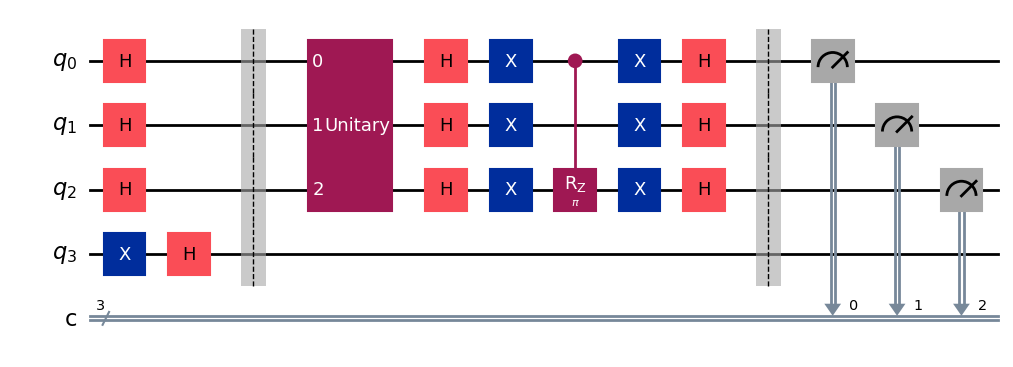

In [51]:
n = 4

circ_grover = mgrover(n,matrix_oracle,1)  # 1 or 2 is the square root of the number of element, that is, four (2 qbits)
#print(oracle_matrix)
circ_grover.draw(output = 'mpl')


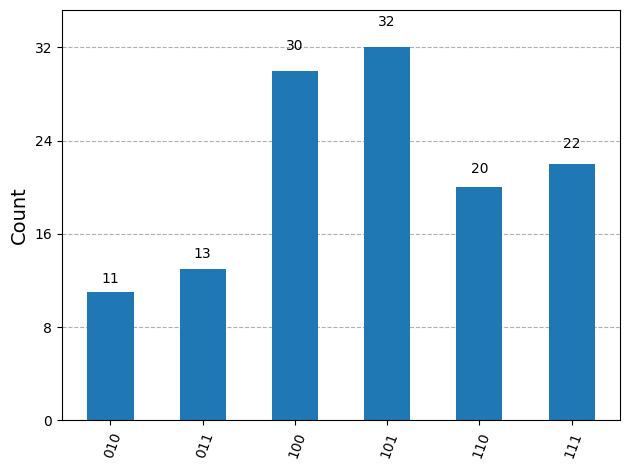

In [52]:
from qiskit_aer import AerSimulator
shots = 128
result = AerSimulator().run(circ_grover, shots=shots, memory=True).result()
answer=result.get_counts()
plot_histogram(answer)
